In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [6]:
!pip install https://github.com/fastai/fastai/archive/master.zip
!pip install opencv-python
!apt update && apt install -y libsm6 libxext6
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip install torchvision
!mkdir data/pascal/
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -P data/pascal/
!wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip -P data/pascal/
!tar -xf data/pascal/VOCtrainval_06-Nov-2007.tar -C data/pascal/
!unzip data/pascal/PASCAL_VOC.zip -d data/pascal/
!mv data/pascal/VOCdevkit/VOC2007 data/pascal/PASCAL_VOC
!rm -rf data/pascal/PASCAL_VOC.zip data/pascal/VOCtrainval_06-Nov-2007.tar

    100% |████████████████████████████████| 90.0MB 243kB/s ta 0:00:011


  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4b/2a/0276479a4b3caeb8a8c1af2f8e4355746a97fab05a372e4a2c6a6b876165/idna-2.7-py2.py3-none-any.whl
  Running setup.py bdist_wheel for fastai ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-bQQsYn/wheels/64/3d/9f/d12a217aa2531321c5b9ae96288fcae2687d3b744376e8f94f
Successfully built fastai
launchpadlib 1.10.3 requires testresources, which is not installed.
tensorflow 1.8.0 has requirement enum34>=1.1.6, but you'll have enum34 1.1.2 which is incompatible.
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 3.1.2 which is incompatible.
tensorboard 1.8.0 has requirement futures>=3.1.1; python_version < "3", but you'll have futures 3.0.5 which is incompatible.
tensorboard 1.8.0 has requirement html5lib==0.9999999, but you'll have html5lib 0.999 which is i

mkdir: cannot create directory ‘data/pascal/’: File exists
URL transformed to HTTPS due to an HSTS policy
--2018-06-28 13:49:45--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘data/pascal/VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  1.97MB/s    in 3m 10s  

2018-06-28 13:52:56 (2.31 MB/s) - ‘data/pascal/VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2018-06-28 13:52:56--  https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.204.80, 2a00:1450:4009:814::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.204.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [5]:
#from fastai.conv_learner import *
#from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

ImportError: No module named pathlib

## Pascal VOC

We will be looking at the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset. It's quite slow, so you may prefer to download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

Unlike previous lessons, we are using the python 3 standard library `pathlib` for our paths and file access. Note that it returns an OS-specific class (on Linux, `PosixPath`) so your output may look a little different. Most libraries than take paths as input can take a pathlib object - although some (like `cv2`) can't, in which case you can use `str()` to convert it to a string.

In [4]:
PATH = Path('data/pascal/PASCAL_VOC')
list(PATH.iterdir())

[PosixPath('data/pascal/PASCAL_VOC/pascal_val2012.json'),
 PosixPath('data/pascal/PASCAL_VOC/pascal_val2007.json'),
 PosixPath('data/pascal/PASCAL_VOC/pascal_test2007.json'),
 PosixPath('data/pascal/PASCAL_VOC/pascal_train2012.json'),
 PosixPath('data/pascal/PASCAL_VOC/VOC2007'),
 PosixPath('data/pascal/PASCAL_VOC/pascal_train2007.json')]

As well as the images, there are also *annotations* - *bounding boxes* showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so we uses the more recent JSON version which you can download from [this link](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip).

You can see here how `pathlib` includes the ability to open files (amongst many other capabilities).

In [5]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [7]:
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [8]:
trn_j[CATEGORIES][:4]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'}]

It's helpful to use constants instead of strings, since we get tab-completion and don't mistype.

In [0]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [10]:
list((PATH/'VOC2007').iterdir())

[PosixPath('data/pascal/PASCAL_VOC/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/PASCAL_VOC/VOC2007/ImageSets'),
 PosixPath('data/pascal/PASCAL_VOC/VOC2007/JPEGImages'),
 PosixPath('data/pascal/PASCAL_VOC/VOC2007/Annotations'),
 PosixPath('data/pascal/PASCAL_VOC/VOC2007/SegmentationObject')]

In [0]:
JPEGS = 'VOC2007/JPEGImages'

In [12]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/PASCAL_VOC/VOC2007/JPEGImages/009573.jpg'),
 PosixPath('data/pascal/PASCAL_VOC/VOC2007/JPEGImages/007280.jpg'),
 PosixPath('data/pascal/PASCAL_VOC/VOC2007/JPEGImages/001675.jpg'),
 PosixPath('data/pascal/PASCAL_VOC/VOC2007/JPEGImages/001611.jpg'),
 PosixPath('data/pascal/PASCAL_VOC/VOC2007/JPEGImages/002759.jpg')]

Each image has a unique ID.

In [13]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

('000012.jpg', 12)

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

In [14]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

2501

In [15]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [16]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [17]:
cats[7]

'car'

In [18]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [19]:
cats[15],cats[13]

('person', 'horse')

Some libs take VOC format bounding boxes, so this let's us convert back when required:

In [0]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

You can use [Visual Studio Code](https://code.visualstudio.com/) (vscode - open source editor that comes with recent versions of Anaconda, or can be installed separately), or most editors and IDEs, to find out all about the `open_image` function. vscode things to know:

- Command palette (<kbd>Ctrl-shift-p</kbd>)
- Select interpreter (for fastai env)
- Select terminal shell
- Go to symbol (<kbd>Ctrl-t</kbd>)
- Find references (<kbd>Shift-F12</kbd>)
- Go to definition (<kbd>F12</kbd>)
- Go back (<kbd>alt-left</kbd>)
- View documentation
- Hide sidebar (<kbd>Ctrl-b</kbd>)
- Zen mode (<kbd>Ctrl-k,z</kbd>)

In [0]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

Matplotlib's `plt.subplots` is a really useful wrapper for creating plots, regardless of whether you have more than one subplot. Note that Matplotlib has an optional object-oriented API which I think is much easier to understand and use (although few examples online use it!)

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

A simple but rarely used trick to making text visible regardless of background is to use white text with black outline, or visa versa. Here's how to do it in matplotlib.

In [0]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

In [0]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [0]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

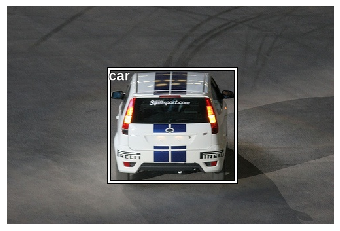

In [26]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [0]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [0]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


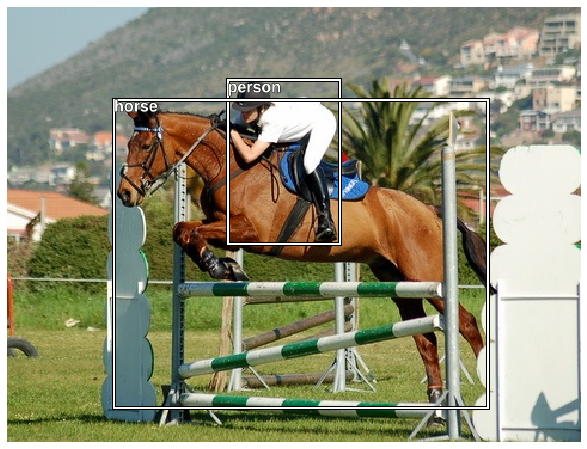

In [29]:
draw_idx(17)

## Largest item classifier

A *lambda function* is simply a way to define an anonymous function inline. Here we use it to describe how to sort the annotation for each image - by bounding box size (descending).

In [0]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [0]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

In [32]:
trn_lrg_anno

{12: (array([ 96, 155, 269, 350]), 7),
 17: (array([ 77,  89, 335, 402]), 13),
 23: (array([  1,   2, 461, 242]), 15),
 26: (array([124,  89, 211, 336]), 7),
 32: (array([ 77, 103, 182, 374]), 1),
 33: (array([106,   8, 262, 498]), 1),
 34: (array([166, 115, 399, 359]), 19),
 35: (array([ 97, 217, 317, 464]), 15),
 36: (array([ 78,  26, 343, 318]), 12),
 42: (array([ 31, 262, 294, 499]), 19),
 44: (array([  0,   0, 329, 369]), 9),
 47: (array([  0,  14, 311, 458]), 7),
 48: (array([  0,   1, 499, 301]), 15),
 61: (array([ 10, 273, 278, 436]), 4),
 64: (array([ 22,   0, 499, 450]), 3),
 66: (array([181, 241, 258, 273]), 15),
 73: (array([142, 120, 459, 374]), 16),
 77: (array([  0,   1, 332, 305]), 8),
 78: (array([ 74,  14, 411, 474]), 12),
 83: (array([ 32, 108, 308, 446]), 7),
 89: (array([ 50,  21, 290, 316]), 9),
 91: (array([240, 124, 283, 194]), 7),
 104: (array([  6,   1, 332, 282]), 15),
 112: (array([173,  69, 327, 276]), 12),
 122: (array([ 19,  35, 473, 429]), 8),
 129: (arr

Now we have a dictionary from image id to a single bounding box - the largest for that image.

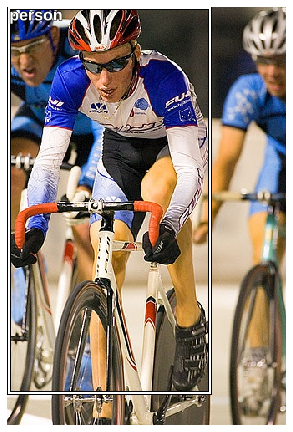

In [33]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [0]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

Often it's easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. Here we use Pandas to help us create a CSV of the image filename and class.

In [0]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [0]:
f_model = resnet34
sz=224
bs=32

From here it's just like Dogs vs Cats!

In [0]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

In [0]:
x,y=next(iter(md.val_dl))

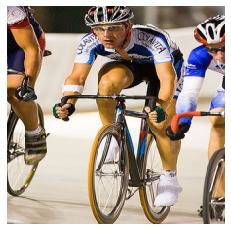

In [39]:
show_img(md.val_ds.denorm(to_np(x))[0]);

In [40]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 79902741.68it/s]


In [41]:
lrf=learn.lr_find(1e-5,100)

 81%|████████▏ | 26/32 [00:19<00:04,  1.35it/s, loss=38]  

When you LR finder graph looks like this, you can ask for more points on each end:

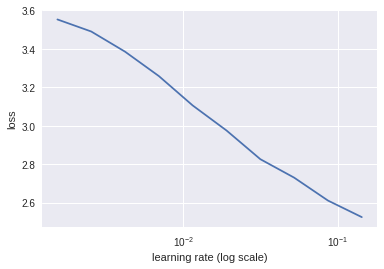

In [42]:
learn.sched.plot()

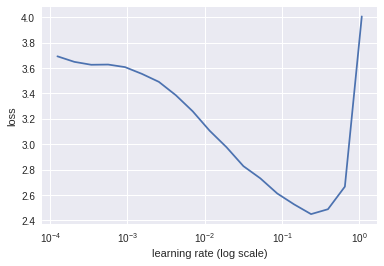

In [43]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [0]:
lr = 2e-2

In [45]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.299836   0.622881   0.804     


[array([0.62288]), 0.8039999995231628]

In [0]:
lrs = np.array([lr/1000,lr/100,lr])

In [0]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:23<00:04,  1.16it/s, loss=4.01]

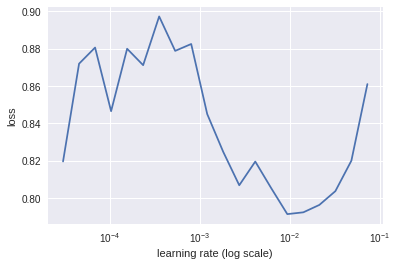

In [48]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [49]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.79312    0.598498   0.806     


[array([0.5985]), 0.8059999995231628]

In [0]:
learn.unfreeze()

Accuracy isn't improving much - since many images have multiple different objects, it's going to be impossible to be that accurate.

In [51]:
learn.fit(lrs/5, 1, cycle_len=3)

epoch      trn_loss   val_loss   accuracy   
    0      0.620691   0.57297    0.818     
    1      0.444861   0.563808   0.832     
    2      0.345734   0.564777   0.826     


[array([0.56478]), 0.8260000023841858]

In [0]:
learn.save('clas_one')

In [0]:
learn.load('clas_one')

In [0]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

You can use the python debugger `pdb` to step through code.

- `pdb.set_trace()` to set a breakpoint
- `%debug` magic to trace an error

Commands you need to know:

- s / n / c
- u / d
- p
- l

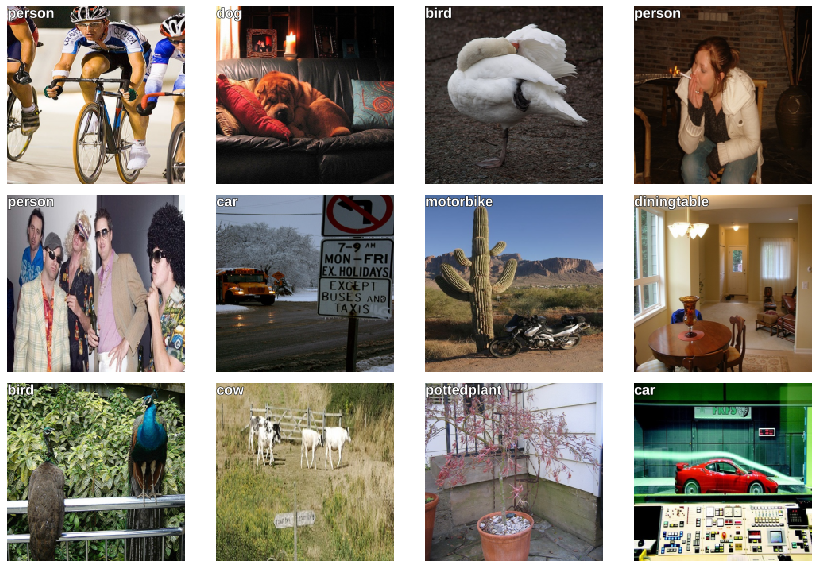

In [55]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

It's doing a pretty good job of classifying the largest object!

## Bbox only

Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.

In [0]:
BB_CSV = PATH/'tmp/bb.csv'

In [0]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [58]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [0]:
f_model=resnet34
sz=224
bs=32

Set `continuous=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use CropType.NO because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it's generally large and centrally located).

In [0]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

In [0]:
x,y=next(iter(md.val_dl))

In [62]:
ima=md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0])); b

array([ 49.,   0., 131., 205.], dtype=float32)

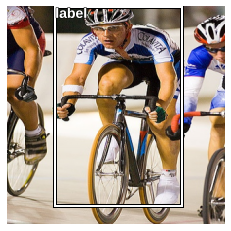

In [63]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

fastai let's you use a `custom_head` to add your own module on top of a convnet, instead of the adaptive pooling and fully connected net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continuous, not categorical, so the MSE loss function used does not do any sigmoid or softmax to the module outputs.

In [0]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [65]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

 78%|███████▊  | 25/32 [00:17<00:04,  1.43it/s, loss=490]

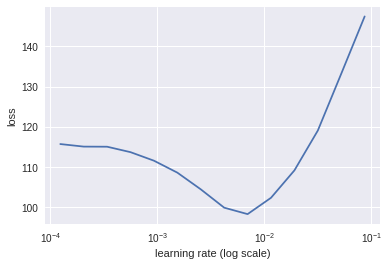

In [66]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [0]:
lr = 2e-3

In [68]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      48.519523  34.417823 
    1      36.953475  28.303326 
    2      30.929975  27.645437 


[array([27.64544])]

In [0]:
lrs = np.array([lr/100,lr/10,lr])

In [0]:
learn.freeze_to(-2)

epoch      trn_loss   val_loss   
    0      65.255408  3652647079240532.0


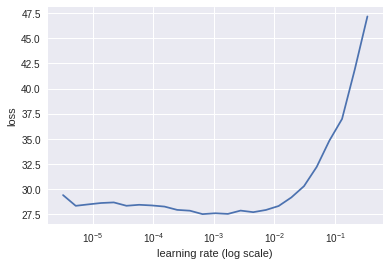

In [71]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [72]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      26.322342  23.21437  
    1      21.940055  21.208905 
    2      17.793071  20.572726 


[array([20.57273])]

In [0]:
learn.freeze_to(-3)

In [74]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss   
    0      17.229308  21.227463 
    1      14.991633  20.594011 


[array([20.59401])]

In [0]:
learn.save('reg4')

In [0]:
learn.load('reg4')

In [0]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

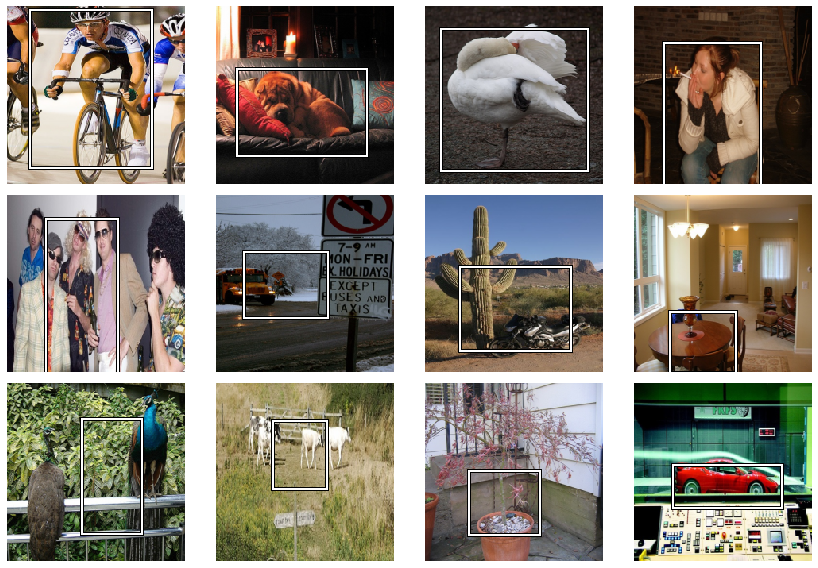

In [78]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## Single object detection

In [0]:
f_model=resnet34
sz=224
bs=32

val_idxs = get_cv_idxs(len(trn_fns))

In [0]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, val_idxs=val_idxs)

In [0]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

A dataset can be anything with `__len__` and `__getitem__`. Here's a dataset that adds a 2nd label to an existing dataset:

In [0]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

We'll use it to add the classes to the bounding boxes labels.

In [0]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [84]:
val_ds2[0][1]

(array([  0.,  49., 205., 180.], dtype=float32), 14)

We can replace the dataloaders' datasets with these new ones.

In [0]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

We have to `denorm`alize the images from the dataloader before they can be plotted.

In [86]:
x,y=next(iter(md.val_dl))

ima=md.val_ds.ds.denorm(to_np(x))[1]
b = bb_hw(to_np(y[0][1])); b

array([  1.,  63., 222., 159.], dtype=float32)

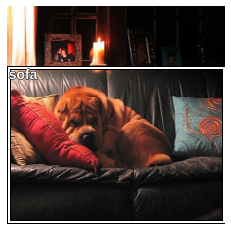

In [87]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][1]])

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

In [0]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [0]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

 97%|█████████▋| 31/32 [00:18<00:00,  1.65it/s, loss=780]

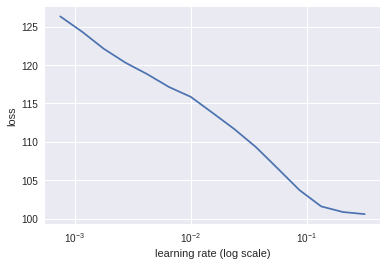

In [90]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr=1e-2

In [92]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      73.114743  43.837588  0.796      31.1003   
    1      51.183383  37.802395  0.814      26.320813 
    2      41.299081  35.290578  0.818      24.637936 


[array([35.29058]), 0.8180000009536743, 24.637935760498046]

In [0]:
learn.save('reg1_0')

In [0]:
learn.freeze_to(-2)

In [0]:
lrs = np.array([lr/100, lr/10, lr])

 88%|████████▊ | 28/32 [00:24<00:03,  1.16it/s, loss=139] 

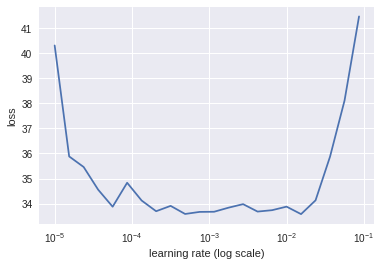

In [96]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [97]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      34.800449  33.596027  0.822      22.313464 
    1      28.738234  34.718903  0.808      22.14421  
    2      24.978815  33.974752  0.808      21.325548 
    3      22.156658  32.603417  0.81       20.557671 
    4      19.969148  32.245513  0.822      20.463348 


[array([32.24551]), 0.8219999980926513, 20.46334780883789]

In [0]:
learn.save('reg1_1')

In [0]:
learn.load('reg1_1')

In [0]:
learn.unfreeze()

In [101]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      17.811456  33.370514  0.824      21.026283 
    1      17.230557  32.296241  0.82       20.244229 
    2      16.557404  33.316849  0.8        20.333166 
    3      15.738766  32.756725  0.8        19.783875 
    4      14.74048   31.733707  0.83       19.492381 
    5      13.855133  31.374471  0.816      19.211263 
  9%|▉         | 3/32 [00:07<01:08,  2.38s/it, loss=13.7]    6      13.087251  30.991985  0.828      18.899216 
    7      12.424033  30.91645   0.824      18.837247 
    8      11.938604  31.618001  0.822      18.993862 
    9      11.556359  31.605803  0.824      18.967525 


[array([31.6058]), 0.8240000014305114, 18.967525299072264]

In [0]:
learn.save('reg1')

In [0]:
learn.load('reg1')

In [0]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [0]:
from scipy.special import expit

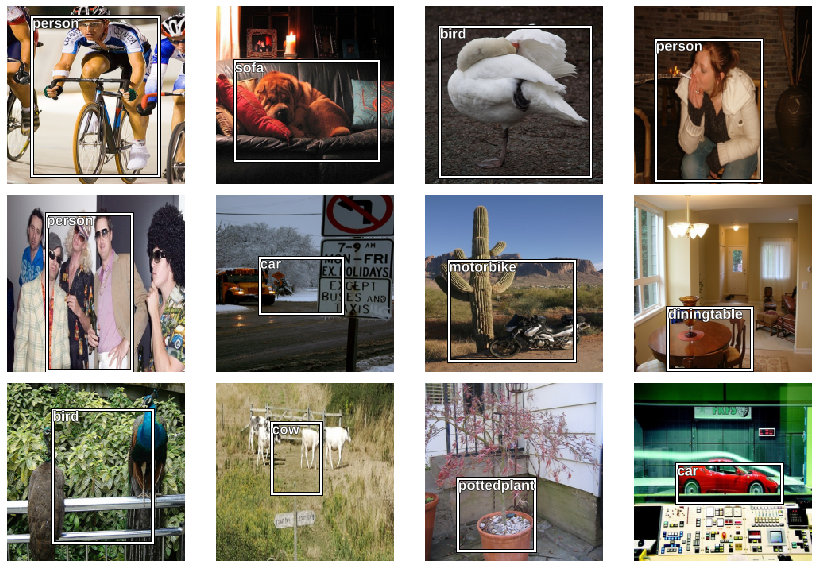

In [106]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()

## End

In [52]:
!ls


data  datalab
